In [1]:
from geofeather import to_geofeather, from_geofeather
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import glob, time
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
gpd.options.use_pygeos = True

In [20]:
def get_input():
    
    '''
    Prompts user for lat, lon input
    and returns a Shapely point
    '''
    
    point = input("Please, enter a geographical coordinante (lat, lon)" )
    
    point = point.split(",")
        
    point = [float(coord.strip()) for coord in point]
    
    point = Point(point[1], point[0]) # Shapely requires a lon, lat point
    
#     point = Point(-46.6598, -23.5318)
    
    return point

In [33]:
def covid_count():
    return 1000000

In [34]:
def find_user_area(point, target):
    
    '''
    Finds the area that we will need to
    process according to the position of the point
    '''
    
    # Loads the quadrant data
    
    reference_map = from_geofeather("../data/index_bboxes.feather")
       
    # Finds in which quadrant the point falls
    
    user_area = reference_map[ reference_map.geometry.contains(point) ].reset_index(drop=True)
        
    assert user_area.shape[0] == 1
    
    user_area = user_area.loc[0]
    
    # Checks if the population is enough
    
    population_in_area = 0
    
    quadrants_to_load = [ ]
    
    while population_in_area < target:
        
        population_in_area += user_area.total_population
        
        # Check if the quadrant has enough population
        
        if user_area.total_population > target:
        
            quadrants_to_add = (str(user_area.id_no) + "|" + user_area.neighbors).split("|")
            
            quadrants_to_load.extend(quadrants_to_add)

        else:
            
            # raise ValueError("Insufficient population")
        
            # TO DO: add the neighbors populations
            for 
            
            # TO DO: mark the neighbors' neighbors for loading as well
        
            pass
    
    # Loads the data in
    
    gdfs = [ ]
    
    quadrants = reference_map [reference_map.id_no.astype(str).isin(quadrants_to_load) ]
    
    for index, row in quadrants.iterrows():
        
        fpath = row.fpath
        
        gdf = from_geofeather(fpath)
        
        gdfs.append(gdf)
        
    return pd.concat(gdfs)

In [35]:
def read_data(path_to_tracts, path_to_shp):
    
    dtype = { 
        
        "CD_GEOCODI": str,
        "CD_GEOCODM": str,
        "CD_MUNICIP": str,
        "Cod_setor": str
        
    }
    
    tracts = pd.read_csv(path_to_tracts, dtype=dtype)
    
    shp = gpd.read_file(path_to_shp, dtype=dtype)
    
    return tracts, shp

In [36]:
def merge_tracts_and_shape(tracts, shp):
    
    return shp.merge(tracts, left_on='CD_GEOCODI', right_on='Cod_setor', how='left')

In [49]:
def find_radius(point, tracts, spatial_index, target):
    
    ########################
    ### HELPER FUNCTIONS ###
    ########################
    
    def find_intersections(tracts, spatial_index, area):
        '''
        Finds all the polygons that intersect a given radius
        '''
        
        # Uses Geopandas/PyGeos rtree to pre-filter the tracts
        nearby_index = list(spatial_index.intersection(area.bounds))
        
        nearby_tracts = tracts.iloc[nearby_index]
        
        # Selects the tracts that do intersect with the area
        matches = nearby_tracts [ nearby_tracts.geometry.intersects(area)]
        
        return matches
        
                    
    def compute_population_in_area(matches, area):
        '''
        Calculates how many people live in the intersecting polygons.
        Also returns an array with the intersecting shapes.
        '''

        def process_intersection(population, tract, polygon):

            intersection = tract.intersection(polygon)

            intersection_percentage = intersection.area / tract.area 

            population_in_intersection = population * intersection_percentage

            return intersection, population_in_intersection

        intersection, population_in_intersection = process_intersection(matches.populacao_residente.values,
                                         matches.geometry.values,
                                         area)

        matches['geometry'] = intersection
        
        matches['population_in_intersection'] = population_in_intersection

        return matches
    
    #################
    ### EXECUTION ###
    #################
    
    checkpoint = time.time()
    
    total_people = 0
    
    radius = .001 # This unit is lat/lon degrees
    
    # While we don't meet the population target, we keep increasing the radius to grab more people
    while True:
        
        total_people = 0
        
        area = point.buffer(radius)
        
        matches = find_intersections(tracts, spatial_index, area)
        
        matches = compute_population_in_area(matches, area)
        
        total_people = round(matches.population_in_intersection.sum())
                
        if total_people < target:
        
            radius = radius * 1.5
            
            continue
        
        # Else, finish the iteration
        else:
            
            break
            
    # Now we can move into the fine-tuning, removing excess 
    # population until we are inside a +- 5% tolerance zone
    
    fine_tune = .5

    while True:
        
        if total_people > target * 1.05:
            
            total_people = 0
            
            radius = radius * (1 - fine_tune)
            
            area = point.buffer(radius)
            
            matches = find_intersections(tracts, spatial_index, area)
        
            matches = compute_population_in_area(matches, area)

            total_people = round(matches.population_in_intersection.sum())
            
            if total_people < target * 1.05 and total_people > target * .95:
                
                break 
        
        elif total_people < target * .95:
            
            total_people = 0
            
            radius = radius * (1 + fine_tune)
            
            area = point.buffer(radius)
            
            matches = find_intersections(tracts, spatial_index, area)
        
            matches = compute_population_in_area(matches, area)

            total_people = round(matches.population_in_intersection.sum())
            
            if total_people < target * 1.05 and total_people > target * .95:
                
                break

        
    # After we computed the total area, we can return the matches and see how they look like!
    print(f"Total people: {total_people}")
    print(f"Time computing area: {round(time.time() - checkpoint, 2)}s")
    
    display(matches[["CD_GEOCODI", "geometry", "population_in_intersection"]])
    
    ax = tracts.plot(figsize=(48,42), column="populacao_residente", cmap="Greys")
    ax.axis("off")
    matches.plot(ax=ax, column="population_in_intersection", cmap='Reds', alpha=1)

In [50]:
def main():
    
    # Gets input from user and turns it into a shapely point
    point = get_input()
    
    # TO DO: discover how many covid-19 deaths we have at this point in time
    target = covid_count()
    
    # Gets the parts of the census tracts with the user data that we need to load
    gdf = find_user_area(point, target)
          
    # Uses a buffer to avoid self-intercepting shapes
    gdf["geometry"] = gdf.geometry.buffer(0)
        
        
    # Creates a sindex to improve search
    spatial_index = gdf.sindex
        
    # Finds the area that we will need to highlight along with the respective population
    find_radius(point, gdf, spatial_index, target)
    
    
    # Saves it as geojson
    pass
    
    # Returns
    pass

Please, enter a geographical coordinante (lat, lon)-25.4177662,-54.5902914
Total people: 104379.0
Time computing area: 0.27s


,CD_GEOCODI,geometry,population_in_intersection
142,410830405000024,"POLYGON ((-54.58605 -25.52147, -54.58603 -25.5...",2.238715
163,410830405000119,"POLYGON ((-54.57280 -25.52010, -54.57256 -25.5...",50.414203
165,410830405000030,"POLYGON ((-54.59187 -25.52160, -54.59183 -25.5...",773.410025
171,410830405000029,"POLYGON ((-54.60059 -25.51471, -54.59391 -25.5...",711.476620
172,410830405000306,"POLYGON ((-54.57738 -25.51685, -54.57695 -25.5...",795.891820
...,...,...,...
142,410830405000073,"POLYGON ((-54.56998 -25.44289, -54.56993 -25.4...",1089.000000
144,410830405000105,"POLYGON ((-54.50185 -25.44415, -54.50314 -25.4...",392.000000
160,410830405000298,"POLYGON ((-54.57972 -25.44930, -54.57990 -25.4...",NaN
165,410830410000002,"POLYGON ((-54.59485 -25.42188, -54.58848 -25.4...",NaN


CPU times: user 1.67 s, sys: 56.3 ms, total: 1.72 s
Wall time: 2 s


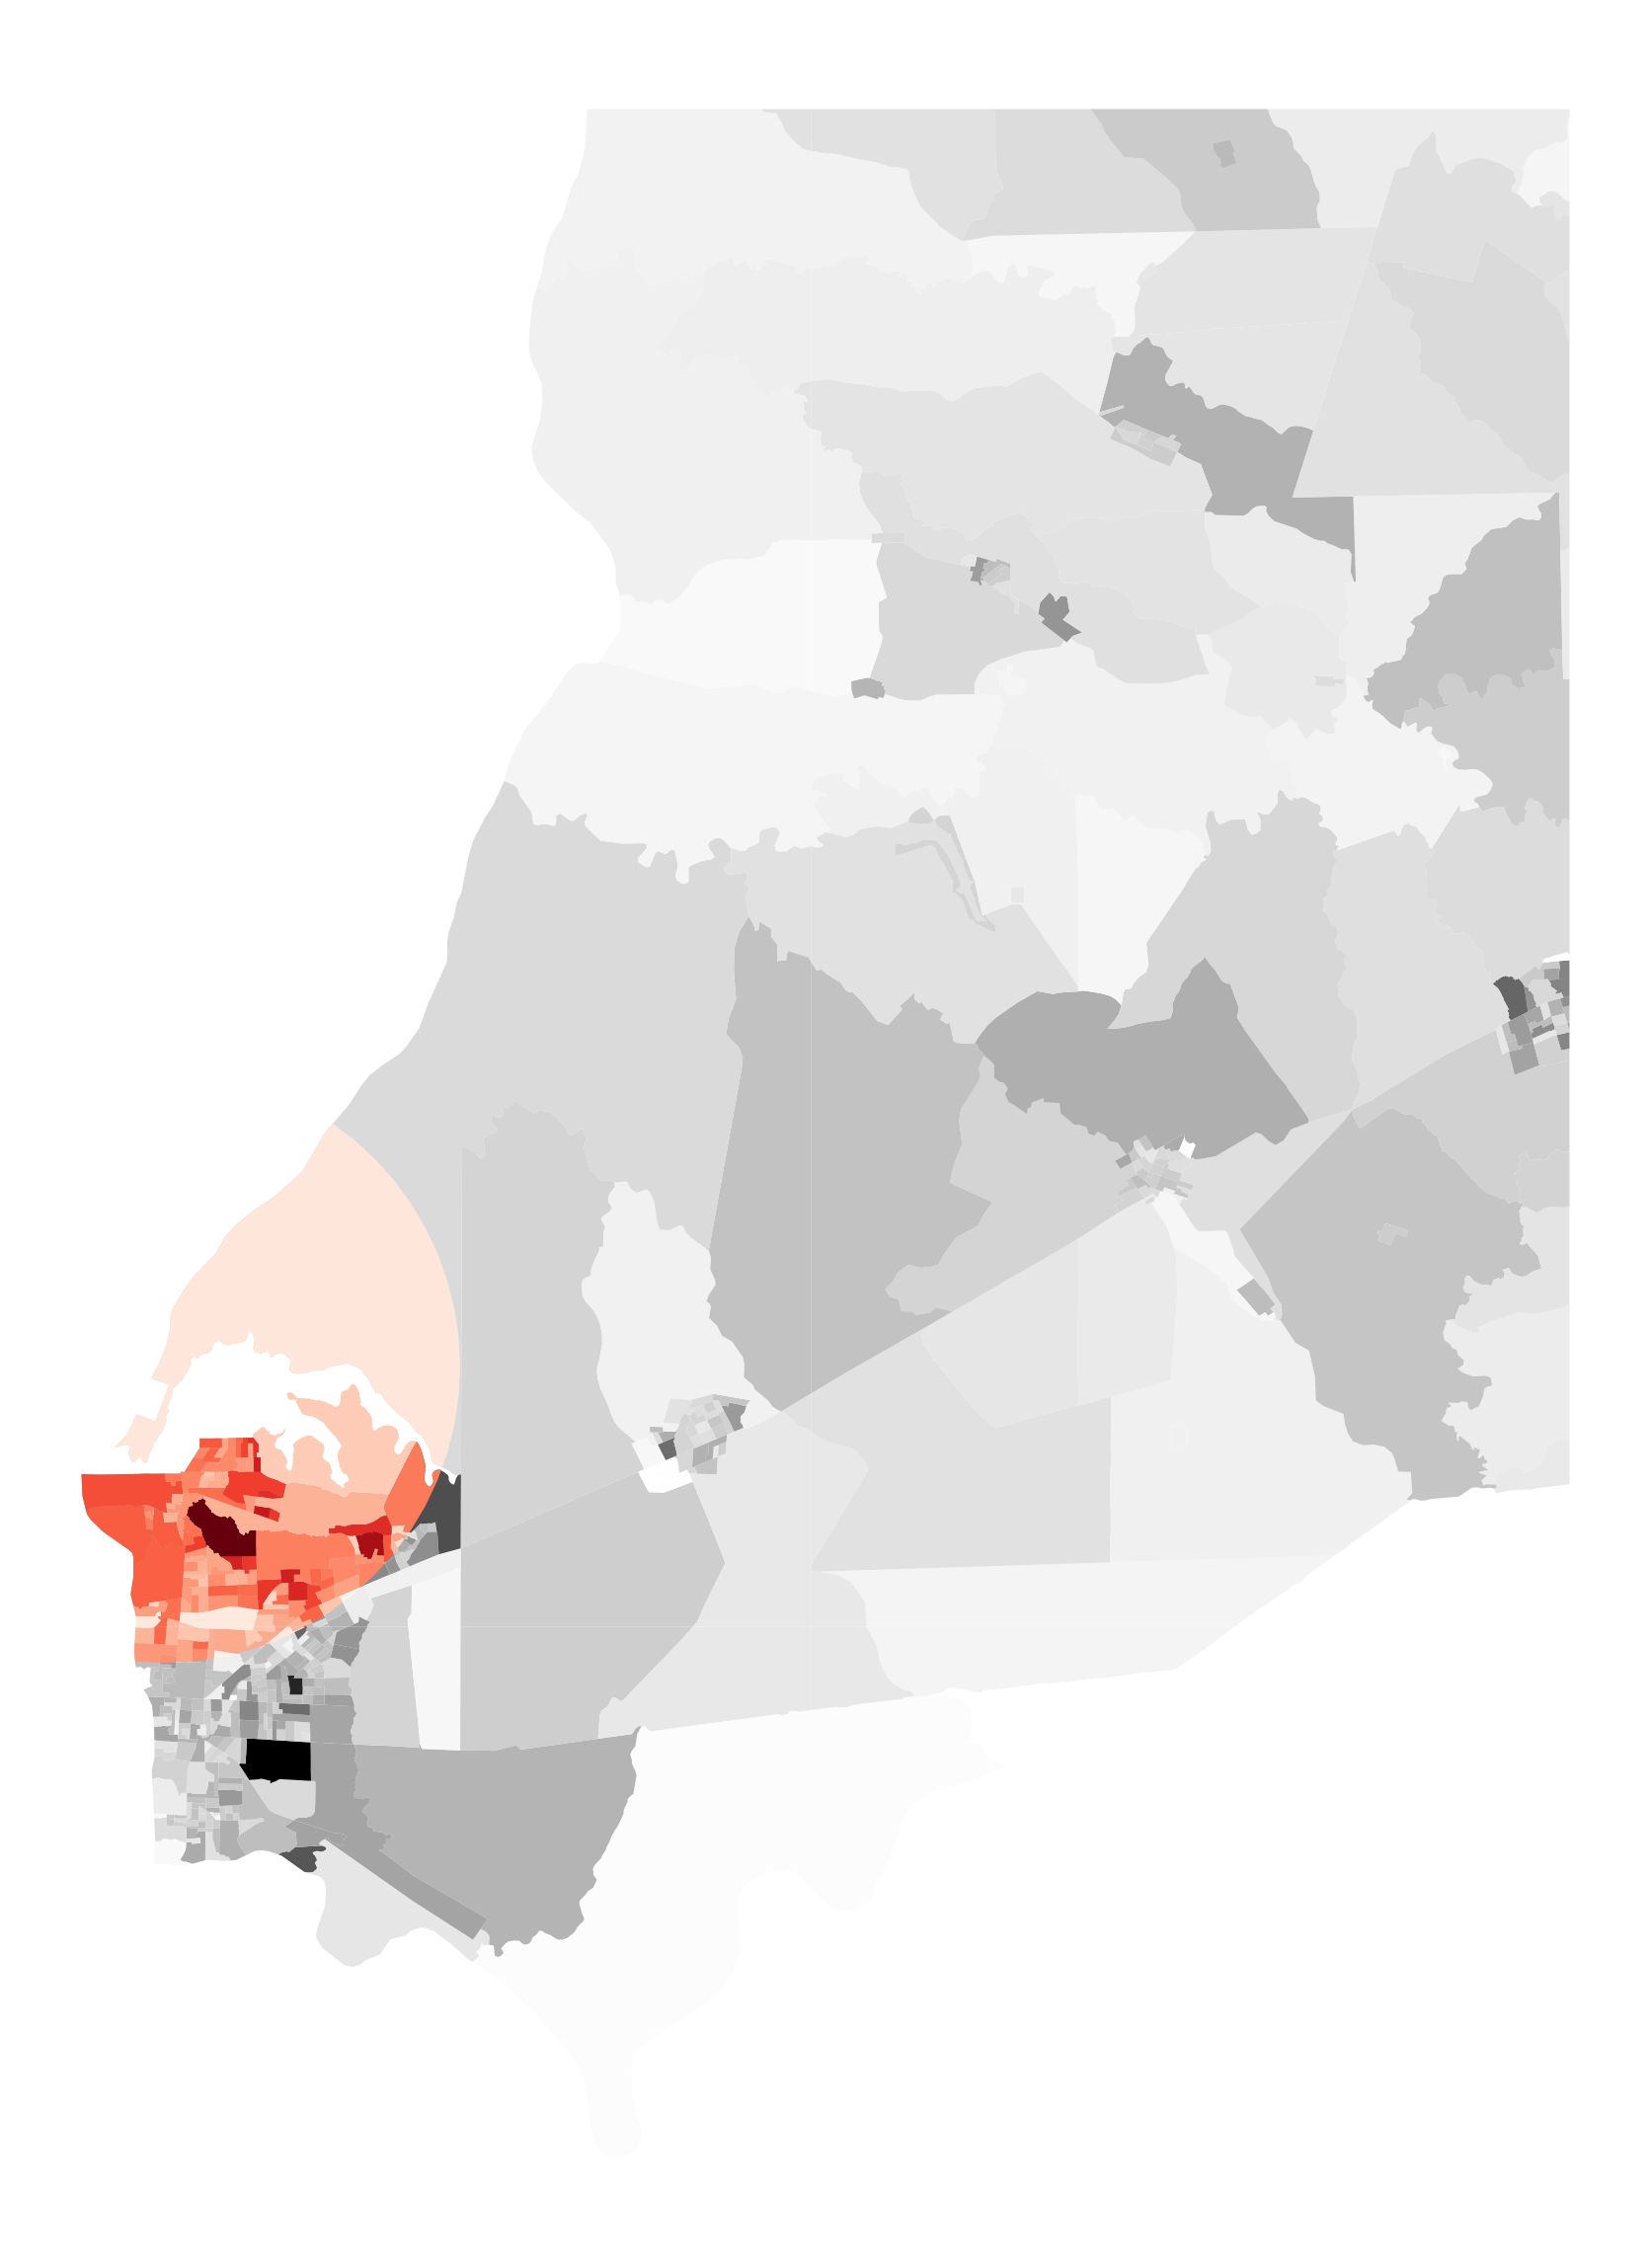

In [54]:
%%time
if __name__ == "__main__":
    main()